In [194]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import os
import itertools
import numpy.ma as ma
from tqdm import tqdm
import networkx as nx 
import seaborn as sns 
import time 
import planarity

In [208]:
year = 2020
corr = pd.read_csv(f'{year} first-level corr.csv',index_col=0)

In [209]:
distance_m = pd.DataFrame(np.tril(np.sqrt((1-corr)/2)))
distance_m.columns=corr.columns
distance_m.index=corr.columns

<AxesSubplot:>

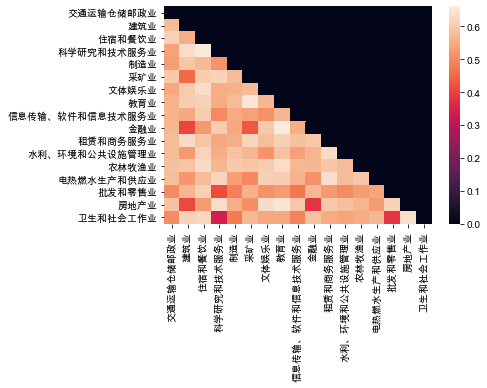

In [210]:
sns.heatmap(distance_m)

In [211]:
zipped = []
for i in range(len(distance_m.columns)):
    zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
List_flat = []
for i in zipped:
    for j in i:
        if not np.isnan(j[2]):
            List_flat.append(j)
s_List_flat = list(set(List_flat))
# print(len(s_List_flat))
List = []
for i in range(len(s_List_flat)):
    # print(s_List_flat[i])
    if float(s_List_flat[i][2])!=0:
        List.append(s_List_flat[i])
G = nx.Graph()
G.add_weighted_edges_from(List)
#     return G

def sort_graph_edges_dist(G):
    sorted_edges = []
    tmp = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse = False)
    for source, dest, data in tmp: # in descending order!
        sorted_edges.append({'source': source,
                            'dest': dest,
                            'weight': data['weight']})
    return sorted_edges

def compute_PMFG(G):
    PMFG = nx.Graph() 
    ne_total = G.number_of_edges()
    nb_nodes = len(G.nodes)
    ne_pmfg = 3*(nb_nodes-2)
    sorted_edges = sort_graph_edges_dist(G)
    t0 = time.time()
    for i, edge in enumerate(sorted_edges):
        PMFG.add_edge(edge['source'], edge['dest'], weight = edge['weight'])
        if not planarity.is_planar(PMFG):
            PMFG.remove_edge(edge['source'], edge['dest'])
        ne = PMFG.number_of_edges()
        print("Generating PMFG... added edges in PMFG %d/%d (%.2f%%) lookup edges in G %d/%d (%.2f%%) Elapsed TIme %.2f [sec]"            %(ne, ne_pmfg, (ne/ne_pmfg)*100, i, ne_total, (i+1/ne_total)*100, time.time()-t0), end="\r")
        if ne == ne_pmfg:
            break
    return PMFG

In [212]:
pmfg = compute_PMFG(G)

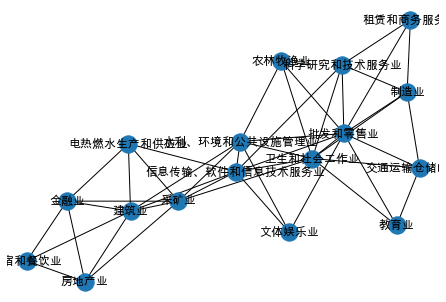

In [213]:
# plt.figure(figsize=(10,10))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw(pmfg,with_labels = True)

In [214]:
degree = dict(pmfg.degree())
sorted(degree.items(), key=lambda x:x[1],reverse=True)

[('批发和零售业', 10),
 ('卫生和社会工作业', 9),
 ('信息传输、软件和信息技术服务业', 8),
 ('建筑业', 7),
 ('采矿业', 7),
 ('水利、环境和公共设施管理业', 7),
 ('科学研究和技术服务业', 5),
 ('金融业', 5),
 ('制造业', 5),
 ('房地产业', 4),
 ('电热燃水生产和供应业', 4),
 ('交通运输仓储邮政业', 4),
 ('文体娱乐业', 3),
 ('租赁和商务服务业', 3),
 ('住宿和餐饮业', 3),
 ('教育业', 3),
 ('农林牧渔业', 3)]

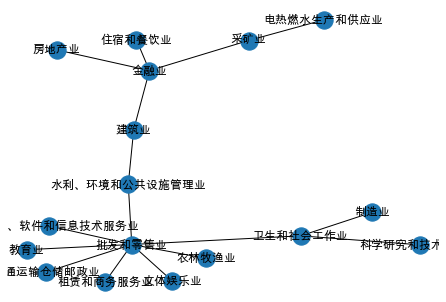

In [215]:
mst = nx.minimum_spanning_tree(G)
nx.draw(mst,with_labels=True)

In [216]:
nodes = G.nodes
edges = dict(G.edges)
# edges


In [217]:
from itertools import combinations

In [218]:
def weight_to_corr(weight):
    return 1-2*weight**2

In [219]:
tmp = list(G.nodes)
Impation = {}
for i in range(len(G.nodes)):
    a = list(G.nodes)
    # 除去一个节点
    # print(tmp[i])
    a.remove(tmp[i])
    # 这个节点外所有的组合，随后获取其相关系数---即Cij
    cobs = list(combinations(a,2))
    # print('除此点外所有组合: \n',cobs)
    # 获得Cik和Cjk
    for j in range(len(cobs)):
        C_ij_k_list = []
        try:
            C_ik = weight_to_corr(edges[(tmp[i],cobs[j][0])]['weight'])
        except:
            C_ik = weight_to_corr(edges[(cobs[j][0],tmp[i])]['weight'])
        try:
            C_jk = weight_to_corr(edges[(tmp[i],cobs[j][1])]['weight'])
        except:
            C_jk = weight_to_corr(edges[(cobs[j][1],tmp[i])]['weight'])
        try:
            C_ij = weight_to_corr(edges[(cobs[j][0],cobs[j][1])]['weight'])
        except:
            C_ij = weight_to_corr(edges[(cobs[j][1],cobs[j][0])]['weight'])
        C_ij_k_list.append(C_ij-(C_ij-C_ik*C_jk)/np.sqrt((1-C_ik**2)*(1-C_jk**2)))
    Impation[tmp[i]]=sum(C_ij_k_list)/((2*len(G.nodes)-1)*(len(G.nodes)-2))


In [220]:
sorted(Impation.items(), key=lambda x:x[1],reverse=True)

[('批发和零售业', 0.0003906162742960393),
 ('卫生和社会工作业', 0.0003241311806408078),
 ('科学研究和技术服务业', 0.000242517825536784),
 ('信息传输、软件和信息技术服务业', 0.0002000068350418101),
 ('金融业', 0.0001936663632405897),
 ('制造业', 0.00018128364686371073),
 ('水利、环境和公共设施管理业', 0.00017540063898734538),
 ('房地产业', 0.00016806948909669036),
 ('文体娱乐业', 0.00015700622811273699),
 ('农林牧渔业', 0.00015294004595102934),
 ('建筑业', 0.00015242777484078424),
 ('租赁和商务服务业', 0.0001451931950969844),
 ('电热燃水生产和供应业', 0.00014381763400027534),
 ('交通运输仓储邮政业', 0.00013087055237780696),
 ('采矿业', 0.00012302792719706134),
 ('教育业', 9.463416833216196e-05),
 ('住宿和餐饮业', 6.999296174148967e-05)]